In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def sinkhorn_with_polarization(C, a, b, P, P_max, epsilon, dual_lr=0.1, precision=1e-6, max_iter=10000):
    n, m = C.shape
    kappa = 0.0
    u = np.ones((n, 1))
    v = np.ones((m, 1))
    convergence = False

    # Histories for plotting
    polarization_history = []
    engagement_history = []
    objective_history = []
    kappa_history = []
    iteration_history = []

    # Initial adjusted cost matrix and kernel
    per_user_polarization = np.zeros(n)  # Initialize per-user polarization
    sign_per_user_polarization = np.zeros((n, 1))
    C_adjusted = C + kappa * sign_per_user_polarization * P[np.newaxis, :]
    max_exponent = 700
    exponent = -C_adjusted / epsilon
    exponent = np.clip(exponent, -max_exponent, max_exponent)
    K = np.exp(exponent)

    for iteration in range(max_iter):
        # Update scaling factors
        for _ in range(50):
            u_prev = u.copy()
            v_prev = v.copy()
            u = a / np.maximum(K @ v, 1e-100)
            v = b / np.maximum(K.T @ u, 1e-100)
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break

        # Compute transport plan
        Pi = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())

        # Compute per-user polarization
        per_user_polarization = (Pi @ P) / a.flatten()
        average_abs_polarization = np.mean(np.abs(per_user_polarization))
        polarization_history.append(average_abs_polarization)

        # Compute engagement score (-<Pi, C>)
        engagement_score = -np.sum(Pi * C)
        engagement_history.append(engagement_score)

        # Compute objective function value
        entropy_term = -epsilon * np.sum(Pi * (np.log(Pi + 1e-100) - 1))
        objective = engagement_score + entropy_term
        objective_history.append(objective)

        # Store dual variable history
        kappa_history.append(kappa)
        iteration_history.append(iteration)

        # Check polarization constraint
        if average_abs_polarization > P_max + precision:
            # Update dual variable for polarization constraint
            polarization_violation = average_abs_polarization - P_max
            kappa += dual_lr * polarization_violation
            kappa = max(kappa, 0.0)

            # Update adjusted cost matrix and kernel with new kappa
            sign_per_user_polarization = np.sign(per_user_polarization)[:, np.newaxis]
            C_adjusted = C + kappa * sign_per_user_polarization * P[np.newaxis, :]
            exponent = -C_adjusted / epsilon
            exponent = np.clip(exponent, -max_exponent, max_exponent)
            K = np.exp(exponent)
        else:
            # Polarization constraint satisfied
            if err_u < precision and err_v < precision:
                convergence = True
                print(f"Converged at iteration {iteration} with average absolute per-user polarization = {average_abs_polarization:.4f}")
                break

    if not convergence:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
        print(f"Final average absolute per-user polarization = {average_abs_polarization:.4f}")

    results = {
        'Pi': Pi,
        'polarization_history': polarization_history,
        'engagement_history': engagement_history,
        'objective_history': objective_history,
        'kappa_history': kappa_history,
        'iterations': iteration_history,
        'average_abs_polarization': average_abs_polarization,
        'converged': convergence
    }
    return results


In [45]:
# Parameters
n_users = 500
n_content = 400
np.random.seed(42)

# Generate cost matrix C
C = np.random.uniform(-10, 10, size=(n_users, n_content))
C = (C - np.mean(C)) / (np.max(C) - np.min(C))  # Normalize to [-1, 1]

# Generate marginals a and b
a = np.random.uniform(0.1, 1, size=(n_users, 1))
a /= a.sum()
b = np.random.uniform(0.1, 1, size=(n_content, 1))
b /= b.sum()

# Generate polarization scores P
P = np.random.normal(0, 1, size=n_content)  # Standard normal
P = (P - np.mean(P)) / (np.max(P) - np.min(P)) * 0.5  # Rescale to [-0.5, 0.5]

# Set parameters
P_max = 0  # Adjust based on data
epsilon = 0.5  # Larger regularization for stability
dual_lr = 0.05  # Smaller dual learning rate

# Run the Sinkhorn algorithm
results = sinkhorn_with_polarization(
    C, a, b, P, P_max=P_max, epsilon=epsilon, dual_lr=dual_lr, precision=1e-6, max_iter=5000
)

# Extract histories
iterations = results['iterations']
polarization_history = results['polarization_history']
engagement_history = results['engagement_history']
objective_history = results['objective_history']
kappa_history = results['kappa_history']


Reached maximum iterations (5000) without full convergence.
Final average absolute per-user polarization = 0.0345


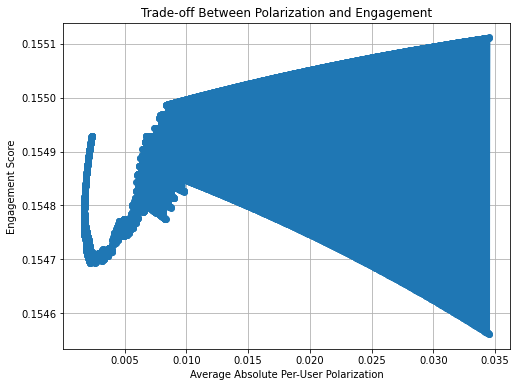

In [41]:

# a. Trade-off Between Polarization and Engagement
plt.figure(figsize=(8, 6))
plt.plot(polarization_history, engagement_history, marker='o')
plt.xlabel('Average Absolute Per-User Polarization')
plt.ylabel('Engagement Score')
plt.title('Trade-off Between Polarization and Engagement')
plt.grid(True)
plt.show()




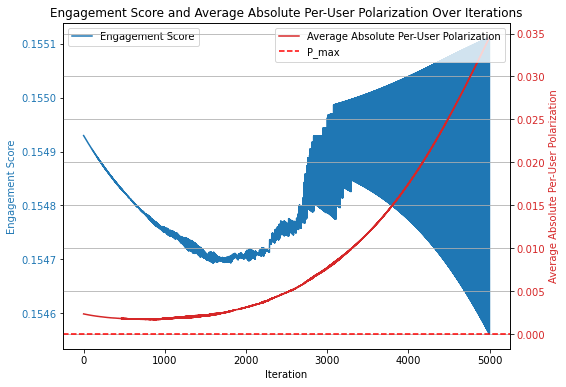

In [42]:
# b. Engagement and Polarization Over Iterations
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Engagement Score', color=color)
ax1.plot(iterations, engagement_history, color=color, label='Engagement Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Average Absolute Per-User Polarization', color=color)
ax2.plot(iterations, polarization_history, color=color, label='Average Absolute Per-User Polarization')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=P_max, color='red', linestyle='--', label='P_max')
ax2.legend(loc='upper right')

plt.title('Engagement Score and Average Absolute Per-User Polarization Over Iterations')
plt.grid(True)
plt.show()



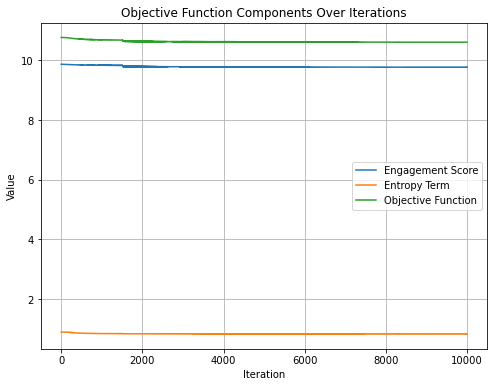

In [30]:
# c. Objective Function Components Over Iterations
plt.figure(figsize=(8, 6))
plt.plot(iterations, engagement_history, label='Engagement Score')
entropy_history = [o - e for e, o in zip(engagement_history, objective_history)]
plt.plot(iterations, entropy_history, label='Entropy Term')
plt.plot(iterations, objective_history, label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Objective Function Components Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

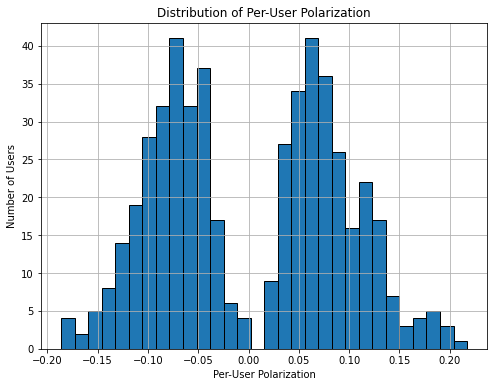

In [31]:
# Compute per-user polarization
Pi = results['Pi']
per_user_polarization = (Pi @ P) / a.flatten()

# Plotting the distribution of per-user polarization
plt.figure(figsize=(8, 6))
plt.hist(per_user_polarization, bins=30, edgecolor='black')
plt.xlabel('Per-User Polarization')
plt.ylabel('Number of Users')
plt.title('Distribution of Per-User Polarization')
plt.grid(True)
#plt.savefig('per_user_polarization.png', dpi=300, bbox_inches='tight')
plt.show()